This notebook to train sequence to sequence model for Arabic punctuation prediction. This project followed the [Neural Machine Translation]((https://www.tensorflow.org/tutorials/text/nmt_with_attention)) which available from TensorFlow.


### Import necessary libraries




In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import pandas as pd

## Prepare data
In this step, we convert input and output files to numeric sequence with length 10 as the maximum length.

In [0]:
def preprocess_sentence(file_name):
    '''
    DESCRIPTION:
    This function to read the file, then add <start> and <end> as a tag in begin and end for each sequence.
    INPUT: 
    file_name: file name
    OUTPUT: 
    text: text after preprocess
    ''' 
    with open(file_name , 'r', encoding='windows-1256') as f:
        text = f.readlines()

    text = ['<start> '+ t.replace('\n','') + ' <end>' for t in text]
    return text


def calculate_max_length(tensor):
    '''
    DESCRIPTION:
    This function to Calculates the max length in tensor
    INPUT: 
    tensor: input tensor
    OUTPUT: 
    _: max length of tensor
    ''' 
    return max(len(t) for t in tensor)

def tokenize(text):
    '''
    DESCRIPTION:
    This function to convert inputs to numeric sequences with the maximum length
    INPUT: 
    text: list of string
    OUTPUT: 
    tokenizer: object of converted text into a sequence of integer
    text_vector: vector of converted text into a sequence of integer
    max_length: max length in text_vector
    ''' 

    # Choose the top 9000 words from the vocabulary
    top_k = 9000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",filters='')
    tokenizer.fit_on_texts(text)
    train_seqs = tokenizer.texts_to_sequences(text)

    #add a word for padding 
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Create the tokenized vectors
    text_seqs = tokenizer.texts_to_sequences(text)

    # Pad each vector to the max_length of the vector
    text_vector = tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding='post')

    # Calculates the max_length, which is used to store the attention weights
    max_length = calculate_max_length(text_seqs)
    
    return tokenizer, text_vector,max_length

In [0]:
# prepare input data
input = preprocess_sentence('input_punctuation.txt')
input_tokenizer, input_tensor ,input_max_length = tokenize(input)

In [0]:
# prepare output data
target = preprocess_sentence('output_punctuation.txt')
target_tokenizer, target_tensor ,target_max_length = tokenize(target)

In [510]:
# data shapes
(input_tensor.shape),(target_tensor.shape) 

((628500, 12), (628500, 12))

In [221]:
def convert(tokenizer, tensor):
    '''
    DESCRIPTION:
    This function to convert index to word for input tensor
    INPUT: 
    tokenizer: object of converted text into a sequence of integer
    tensor: list of integer
    OUTPUT: 
    None
    ''' 
    for t in tensor:
        if t!=0:
              print ("%d ----> %s" % (t, tokenizer.index_word[t]))
    
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor[0])  
print ("Output Language; index to word mapping")
convert(target_tokenizer, target_tensor[0]) 

Input Language; index to word mapping
2 ----> <start>
2368 ----> تم
1 ----> <unk>
39 ----> هذا
1 ----> <unk>
1 ----> <unk>
4048 ----> بواسطة
1 ----> <unk>
1 ----> <unk>
512 ----> الكتاب
87 ----> شرح
3 ----> <end>
Output Language; index to word mapping
3 ----> <start>
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
7 ----> :
2 ----> space
4 ----> <end>


### Data Visualization

In [512]:
target = pd.DataFrame(list(target_tokenizer.word_counts.items())) 
target

,0,1
0,<start>,628500
1,space,5865615
2,:,92871
3,<end>,628500
4,.,95358
5,؛,41361
6,،,187018
7,؟,2770


<BarContainer object of 8 artists>

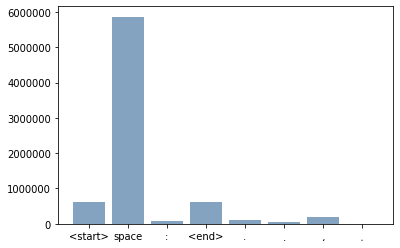

In [432]:
plt.xticks(fontsize =10)
plt.bar(target[0],target[1], color=(0.2, 0.4, 0.6, 0.6))

### Create dataset

In [0]:
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 256
steps_per_epoch = len(input_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

# create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [224]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(256), Dimension(12)]),
 TensorShape([Dimension(256), Dimension(12)]))

## Encoder and decoder model

In this part of the code, we used the same technique of Neural Machine Translation provided by TensorFlow. However, we used Keras with the backend of TensorFlow. For more details can visit [Neural machine translation with attention tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention).

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [226]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (256, 12, 1024)
Encoder Hidden state shape: (batch size, units) (256, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.keras.layers.Activation(activation = "tanh")(tf.keras.layers.Add()([self.W1(values), self.W2(hidden_with_time_axis)])))    

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.keras.layers.Activation(activation = "softmax")(tf.keras.layers.Permute((2, 1))(score))
        attention_weights = tf.keras.layers.Permute((2, 1))(attention_weights)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.keras.layers.Multiply()([attention_weights, values])

        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [228]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (256, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (256, 12, 1)


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.keras.layers.Concatenate(axis = -1)([tf.expand_dims(context_vector, 1), x])

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        #output = tf.keras.layers.Dense(self.dec_units)(output)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.keras.layers.Reshape((output.shape[2],))(output)

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [240]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (256, 11)


### Optimizer and loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Train

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    '''
    DESCRIPTION:
    This function to train encode-decode model
    INPUT: 
    inp: input vector
    targ: target vector
    enc_hidden: encoder initial hidden state
    OUTPUT: 
    batch_loss: train loss
    ''' 

    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [244]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2024
Epoch 1 Batch 100 Loss 0.5358
Epoch 1 Batch 200 Loss 0.5134
Epoch 1 Batch 300 Loss 0.5058
Epoch 1 Batch 400 Loss 0.4831
Epoch 1 Batch 500 Loss 0.4823
Epoch 1 Batch 600 Loss 0.4879
Epoch 1 Batch 700 Loss 0.4299
Epoch 1 Batch 800 Loss 0.4163
Epoch 1 Batch 900 Loss 0.3736
Epoch 1 Batch 1000 Loss 0.2317
Epoch 1 Batch 1100 Loss 0.1912
Epoch 1 Batch 1200 Loss 0.1542
Epoch 1 Batch 1300 Loss 0.1290
Epoch 1 Batch 1400 Loss 0.1254
Epoch 1 Batch 1500 Loss 0.1616
Epoch 1 Batch 1600 Loss 0.1669
Epoch 1 Batch 1700 Loss 0.4251
Epoch 1 Batch 1800 Loss 0.4228
Epoch 1 Batch 1900 Loss 0.1847
Epoch 1 Batch 2000 Loss 0.1584
Epoch 1 Batch 2100 Loss 0.1351
Epoch 1 Batch 2200 Loss 0.1359
Epoch 1 Batch 2300 Loss 0.4841
Epoch 1 Batch 2400 Loss 0.4762
Epoch 1 Loss 0.3359
Time taken for 1 epoch 1180.6459941864014 sec

Epoch 2 Batch 0 Loss 0.4603
Epoch 2 Batch 100 Loss 0.4961
Epoch 2 Batch 200 Loss 0.3089
Epoch 2 Batch 300 Loss 0.1461
Epoch 2 Batch 400 Loss 0.1429
Epoch 2 Batch 500 Loss

### Predict

In [0]:
def evaluate(sentence):
    '''
    DESCRIPTION:
    This function to predict result
    INPUT: 
    sentence: input sentence 
    OUTPUT: 
    result: predict result
    sentence: input sentence 
    attention_plot: attention weights
    ''' 

  attention_plot = np.zeros((target_max_length, input_max_length))

  #sentence = preprocess_sentence(sentence)
  sentence = sentence + ' <end>'
  inputs = [input_tokenizer.texts_to_sequences([i])[0][0] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_max_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

  for t in range(target_max_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_tokenizer.index_word[predicted_id] + ' '

    if target_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  '''
    DESCRIPTION:
    This function to plot attention 
    INPUT: 
    attention: attention weights
    sentence: input sentence 
    predicted_sentence: predict result

    OUTPUT: 
    None
    ''' 
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def predict(sentence):
    '''
    DESCRIPTION:
    This function to predict output sentence

    INPUT: 
    sentence: input sentence 

    OUTPUT: 
    None
    ''' 
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:\n %s' % (sentence))

    predict = ''
    sentence_list = sentence.split(' ')
    result_list = result.split(' ')

    for i in range(len(sentence_list)-1):
      if (result_list[i]=='space'):
        predict += sentence_list[i]+' '
      else:
        predict += sentence_list[i]+result_list[i]+' '
    print('Predicted punctuation:\n {}'.format(predict))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input:
 قال تجنب الكهرباء لأنها خطره <end>
Predicted punctuation:
 قال: تجنب الكهرباء لأنها خطره 


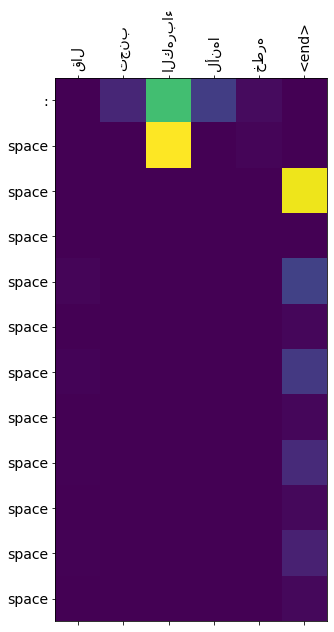

[None]

In [519]:

sentence = 'قال تجنب الكهرباء لأنها خطره'

in_seq = sentence.strip().split(' ')
n =10
in_sequances = [" ".join(in_seq[i:i+n]) for i in range(0, len(in_seq), n)]
[predict(s) for s in in_sequances]

In [0]:
#save the encoder decoder
encoder.save_weights('encoder')
decoder.save_weights('decoder')

In [0]:
#save the dictionary
import csv
def create_csv(file, dict):
    with open(file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for key in dict.keys():
            writer.writerow([key,dict[key]])
create_csv('idx2word_in.csv', input_tokenizer.index_word)
create_csv('idx2word_out.csv', target_tokenizer.index_word)